# <span style="color:green"> Laboratorio di simulazione numerica </span>

### Martina Colombo, 977556


## <span style="color:blue">  Esercitazione 8</span>

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

#### Introduzione

Lo scopo di questa esercitazione è di affrontare la soluzione della ricerca dello stato fondamentale di un sistema formato da una particella quantistica in una dimensione sottoposta a un potenziale esterno $V(x)$ che rende il sistema non integrabile numericamente. 

Il potenziale considerato è
$$
V(x) = x^4 - \frac{5}{2}x^2
$$
cioè un potenziale con una doppia buca. 

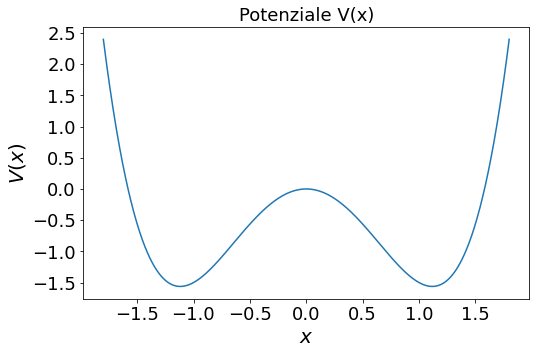

In [39]:
plt.figure(figsize=(8,5))


x=np.linspace(-1.8,1.8, 1000)
plt.title('Potenziale V(x)', fontsize=18)
plt.plot(x, pow(x,4) - 5/2 *pow(x,2))
plt.ylabel('$V(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.grid(True)

plt.show()

Affrontiamo questo problema in due modi: 
1. con un approccio di tipo Variational Monte Carlo (VMC);
2. con tecniche Path Integral Monte Carlo (PIMC/PIGS). 

L'**approccio variazionale** ci dice che per qualsiasi funzione d'onda $\psi_T$, l'energia variazionale ad essa associata è tale per cui 

$$
\left \langle H \right \rangle _{T}= \frac{\left \langle \psi_T |\hat H|  \psi_T\right \rangle} {\left \langle \psi_T |\psi_T\right \rangle} \geq \left \langle H \right \rangle _{0} = \frac{\left \langle \psi_0 |\hat H|  \psi_0\right \rangle} {\left \langle \psi_0 |\psi_0\right \rangle}
$$

quindi $E_T$ sarà minima se la funzione $\psi_T$ è la soluzione esatta del ground state $\psi_0$ dell'equazione di Schrödinger. Il metodo variazionale consiste nel costruire una funzione d'onda dipendente da dei parametri che devono essere ottimizzati così che l'energia associata a questa funzione d'onda parametrica venga minimizzata. L'energia variazionale con i parametri ottimizzati sarà dunque maggiore o uguale a quella dell'effettivo ground state del sistema analizzato e la funzione d'onda associata rappresenterà in generale una buona approssimazione della $\psi_0$. Una volta trovati i parametri che meglio approssimano la $\psi_0$ è possibile calcolare il valore di aspettazione dell'hamiltoniana campionando tramite algoritmo Metropolis il modulo quadro della funzione d'onda.

La tecnica del **Path Integral Monte Carlo** (PIMC) si basa sul fatto che tramite integrali su cammini è possibile mappare un sistema quantistico su un sistema classico di polimeri interagenti tra loro. Il sistema classico in cui si vuole mappare il sistema quantistico ha una struttura che dipende dalla temperatura a cui si considera il sistema, per temperature $T>0$ i polimeri in cui vengono mappate le particelle quantistiche hanno una struttura ad anello, le $M$ particelle che formano un polimero, corrispondenti alle $M$ coordinate introdotte tramite integrale su cammino, interagiscono tra di loro tramite un potenziale di tipo elastico, le particelle di un polimero interagiscono con le particelle che si trovano nella stesso punto della catena di un altro polimero tramite lo stesso tipo di interazione che si ha nel sistema quantistico. Considerando la media quantistica a temperatura finita, applicando la decomposizone di Trotter per $M \to \infty$ alla matrice densità e riscrivendola tramite integrale su cammino, si osserva che la media corrisponde ad un integrale multidimensionale su $M$ coordinate di una quantità che non è altro che una densità di probabilità congiunta, campionando questa distribuzione con l'algoritmo di Metropolis è quindi possibile ottenere il valore di aspettazione dell'osservabile di interesse. Per temperature $T=0$ si parla di Path Integral Ground State (PIGS) il sistema in cui viene mappato una particella quantistica non è più un polimero ad anello ma un polimero lineare. In questo caso partendo da una funzione d'onda di prova e considerando l'evoluzione temporale per tempi immaginari si ha che per tempo immaginario $\tau$ molto grande la funzione di prova diventa proporzionale a quella del ground state. Utilizzando quindi la decomposizione di Trotter per l'operatore di evoluzione temporale immaginario e riscrivendolo tramite integrale di cammino si osserva che la funzione d'onda dello stato fondamentale è approssimata da una serie di convoluzioni che rappresentano singole propagazioni temporali per tempi immaginari a partire da uno stato di prova iniziale. Il valore di aspettazione di un operatore risulta essere un integrale su $2M+1$ coordinate di una densità di probabilità congiunta che può essere campionata tramite algoritmo di Metropolis. Anche in questo caso le particelle del polimero interagiscono tra loro tramite un potenziale di tipo armonico, le particelle appartenenti a due polimeri diversi interagiscono tramite lo stesso tipo di interazione del sistema quantistico negli stessi punti della catena. 


Nel nostro caso consideriamo una funzione d'onda tentativo $\Psi_T^{\sigma, \mu}$ per lo stato fondamentale che sia proporzionale alla somma di due gaussiane, una centrata in $\mu$ e una centrata in $-\mu$ con deviazione standard $\sigma$.

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

### Esericizio 08.1

In questo primo esercizio scriviamo un codice di tipo Variational Monte Carlo (file main_8.1.cpp) per una particella quantistica in 1D che ha lo scopo di calcolare il valor medio dell'Hamiltoniana $\hat H$. 
Il valore di aspettazione dell'Hamiltoniana è dato da:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

per calcolarlo è dunque necessario utilizzare l'algoritmo di Metropolis per campionare il modulo quadro della funzione di prova $|\Psi_T(x)|^2$. Per campionare la distribuzione utilizziamo una probabilità di transizione $T(x_{new}|x_{old})$ di tipo uniforme e teniamo i valori di $\mu$ e $\sigma$ temporaneamente fissati. Integriamo nel codice il calcolo del valor medio dell'Hamiltoniana tramite il metodo a blocchi. 

N.B. nel calcolo del valore di aspettazione di $\langle {\hat H} \rangle_T$ è necessario calcolare analiticamente la derivata seconda della funzione d'onda.

### Esericizio 08.2

Perfezioniamo ora il codice Variational Monte Carlo creato nel primo punto in modo tale che effettui una ricerca dei parametri $\sigma$ e $\mu$ che minimizzano l'energia associata alla funzione d'onda di prova $\Psi_T^{\sigma,\mu}(x)$. A tale scopo creiamo una griglia di $10000$ punti $(\mu, \sigma)$: partendo da $\mu_0=0.7$ e $\sigma_0=0.04$ generiamo $100$ coppie $(\mu_0, \sigma=\sigma_0+i\cdot step)$ con $i=0,...,100$ tenendo fissato $\mu$ e facendo variare $\sigma$ con $step=4\cdot10^{-3}$, poi variamo il valore di $\mu_1=\mu_0+step$ e generiamo altre $100$ coppie di punti $(\mu_1=\mu_0+step, \sigma_1=\sigma_0+i\cdot step)$ fino ad arrivare ad un totale di $10000$ coppie.

I valori di $\sigma$ e $\mu$ iniziali sono stati scelti osservando l'andamento del modulo quadro funzione d'onda dello stato fondamentale del sistema ottenuta trasformando l'equazione di Schrodinger in un'equazione matriciale.
Dalla soluzione numerica conosciamo anche l'energia effettiva del ground state pari a $-0.460465879692715$.

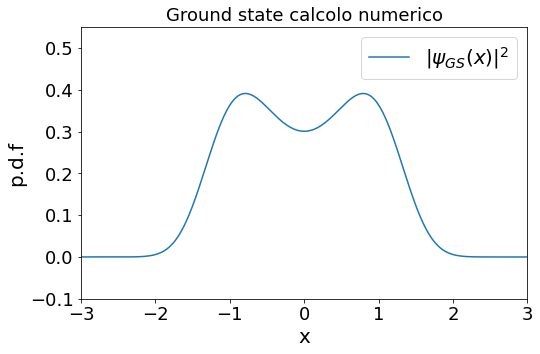

Energia del ground state:  -0.460465879692715


In [210]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

#print("1st excited state energy: ", E[1])
#print("2nd excited state energy: ", E[2])

# Plot 
plt.figure(figsize=(8,5))
scale = 0.3
#plt.plot(x, scale*V, color="Black", label="Potenziale") # plot the potential
plt.plot(x,(psi[0])**2, label='$|\psi_{GS}(x)|^2$')
plt.title("Ground state calcolo numerico", fontsize=18)
plt.xlabel("x", fontsize=20)
plt.ylabel("p.d.f", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
y=np.linspace(-0.6,0.6, 100)
#plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.1,0.55))
plt.legend(loc='upper right', fontsize=20)
plt.show()

print("Energia del ground state: ", E[0])

Per ogni coppia di parametri $(\mu, \sigma)$ effettuiamo $M=10^4$ passi dell'algoritmo Metropolis per calcolare il rispettivo valore di aspettazione. Confrontando i valori delle energie ottimizzate individuiamo la minore e 
i relativi parametri ottimizzati $(\mu_{best}, \sigma_{best})$. 

In [4]:
H_best, mu_best, sigma_best= np.loadtxt("VMC/best_parameters.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
print("Energia minima ottimizzata: ", H_best)
print("mu ottimizzata: ", mu_best)
print('sigma ottimizzata: ', sigma_best)

Energia minima ottimizzata:  -0.463428
mu ottimizzata:  0.808
sigma ottimizzata:  0.604


Riportiamo di seguito in un grafico tridimensionale i valori dell'energia variazionale durante la fase di ottimizzazione.

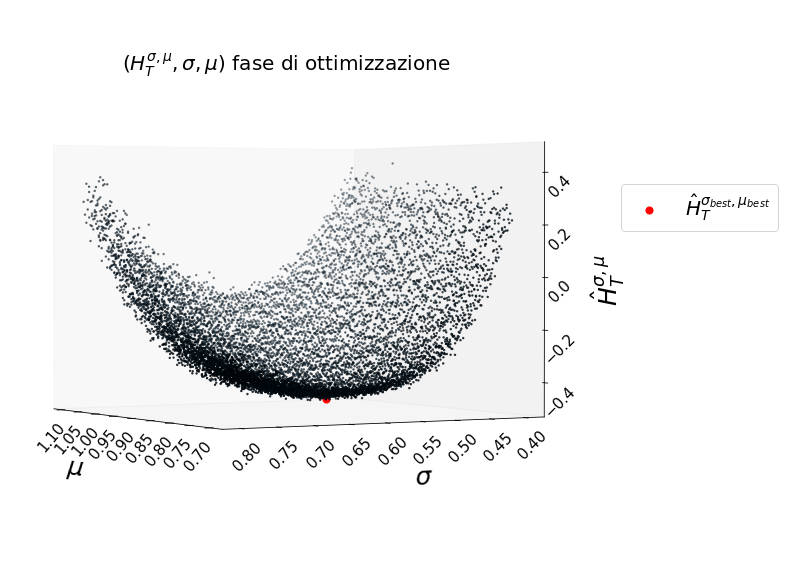

In [5]:
H, mu, sigma=np.loadtxt("VMC/optimization.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(mu, sigma, H, edgecolors='black', s=2)
ax.scatter3D(mu_best, sigma_best, H_best, edgecolors='red', s=50, c = 'red', label='$\hat H_T^{\sigma_{best}, \mu_{best}}$')
ax.set_xlabel('$\mu$', fontsize=25, labelpad=30)
ax.set_ylabel('$\sigma$', fontsize=25, labelpad=30)
ax.set_zlabel('$\hat H_T^{\sigma, \mu}$', fontsize=25, labelpad=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.tick_params(axis='x', which='major', pad=2, rotation=50)
ax.tick_params(axis='y', which='major', pad=2, rotation=45)
ax.tick_params(axis='z', which='major', pad=1, rotation=45)
ax.set_title('$(H_T^{\sigma, \mu}, \sigma, \mu)$ fase di ottimizzazione', y=0.95,  fontsize=20)
ax.view_init(1, 150)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 0.7), fontsize=20)
ax.grid(False)

plt.show()

Utilizziamo poi la coppia di parametri ottimizzati $(\mu_{best}, \sigma_{best})$ per effettuare un nuovo Metropolis con passi Monte Carlo $M=10^5$ da cui otteniamo il valor medio dell'energia tramite il metodo della media a blocchi con $N=10^2$ numero di blocchi. Nell'esecuzione degli algoritmi Metropolis facciamo in modo che il rate di accettazione sia al $50\%$.

- Riportiamo di seguito il grafico del valor medio dell'energia ottenuta utilizzando i parametri variazionali ottimizzati con la relativa incertezza in funzione del numero di blocchi confrontato con il valore numerico ottenuto tramite relativa risoluzione del problema di Schrodinger.

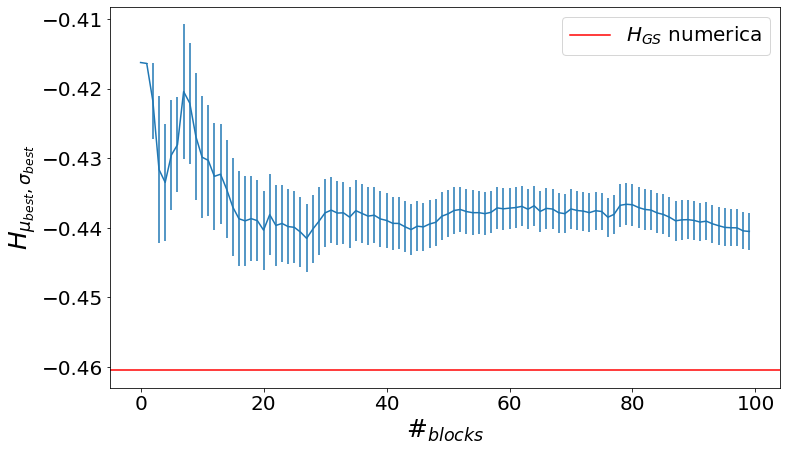

In [247]:
plt.figure(figsize=(12,7))

x, h, err_h= np.loadtxt("VMC/hamiltonian.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(x,h,yerr=err_h)
plt.ylabel('$ H_{\mu_{best}, \sigma_{best}}$', fontsize=25)
plt.xlabel('$\#_{blocks}$', fontsize=25)
plt.axhline(y= -0.46046587969271563 , color='red', label='$H_{GS}$ numerica')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.grid(True)

plt.show()

Dal grafico vediamo che i valori medi dell'energia con i parametri ottimizzati hanno un valore superiore rispetto all'energia effettiva del ground state, risultato che ci aspettavamo avendo utilizzato un principio variazionale.

- Riportiamo di seguito l'istogramma con i punti campionati del modulo quadro della funzione d'onda con i parametri migliori $|\Psi_T^{\sigma_{best},\mu_{best}}(x)|^2$. Confrontiamo questo risultato con la curva analitica $|\Psi_T^{\sigma_{best},\mu_{best}}(x)|^2$ ottenuta utilizzando i parametri $(\mu_{best}, \sigma_{best})$ e con la soluzione numerica $|\psi_{GS}(x)|^2$ ottenuta trasformando l'equazione di Schrodinger in un'equazione matriciale.

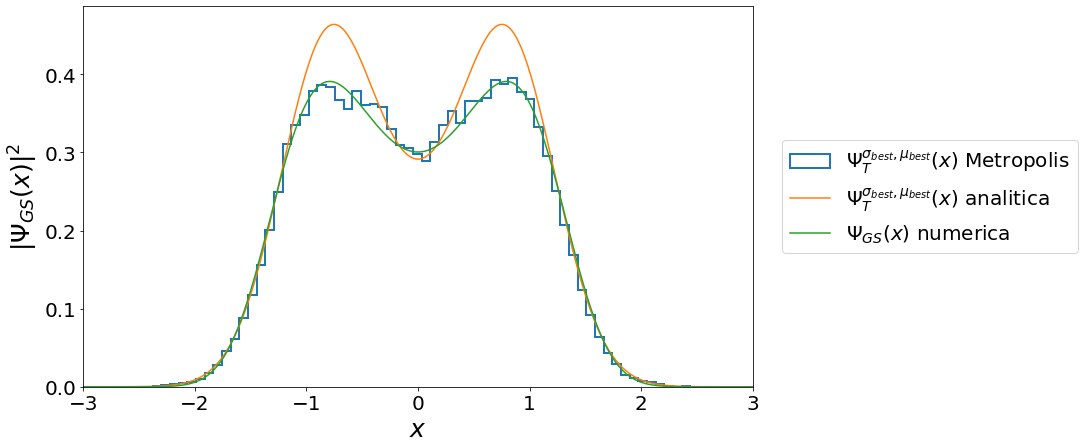

In [2]:
plt.figure(figsize=(12,7))

#Histogram
x= np.loadtxt("VMC/configurations.dat", usecols=0, unpack='true')
plt.hist(x, bins='auto', label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ Metropolis', histtype='step', linewidth=2, density=True)


#Analitica
mu=0.808
sigma=0.604
x=np.linspace(-5,5,1000)
psi_an=np.exp((-(x-mu)**2)/(2*sigma**2))+np.exp((-(x+mu)**2)/(2*sigma**2))
norm=1/(sigma*math.sqrt(2*math.pi))
plt.plot(x,norm*norm*psi_an*psi_an, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ analitica')



#Numerica
#Matrix equation
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x_num = np.linspace(-a/2, a/2, N)
dx = x_num[1] - x_num[0] # the step size
V = Vpot(x_num)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

# Plot 
plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica')
plt.xlabel("$x$", fontsize=25)
plt.ylabel("$|\Psi_{GS}(x)|^2$", fontsize=25)
plt.xlim(-3,3)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Dal grafico vediamo che l'istogramma dei punti campionati corrisponde sia con l'andamento del modulo quadro della funzione d'onda ottenuta tramite soluzione numerica e sia con il modulo quadro della funzione analitica.

### Esercizio 08.3 

Per il terzo esercizio ci viene fornito un codice che risolve con tecniche Path integral Monte Carlo e Path integral Ground State il medesimo problema monodimensionale affrontato nei precedenti esercizi. 


Modifichiamo il codice inserendo:
- il potenziale esterno $V(x) = x^4 - \frac{5}{2}x^2$;
- la funzione d'onda di prova con parametri ottimizzati $\Psi_T^{\sigma_{best},\mu_{best}}(x)$;

Una volta inserite queste modifiche utilizziamo il codice per:

- fare un conto a temperatura T=0 (PIGS) utilizzando come funzione d'onda di prova la funzione costante $\Psi_T(x)=1$;
- fare un conto a T=0 (PIGS) utilizzando la funzione d'onda di prova $\Psi_T^{\sigma_{best},\mu_{best}}(x)$ con i parametri ottimizzati.

Confrontiamo i risultati ottenuti.

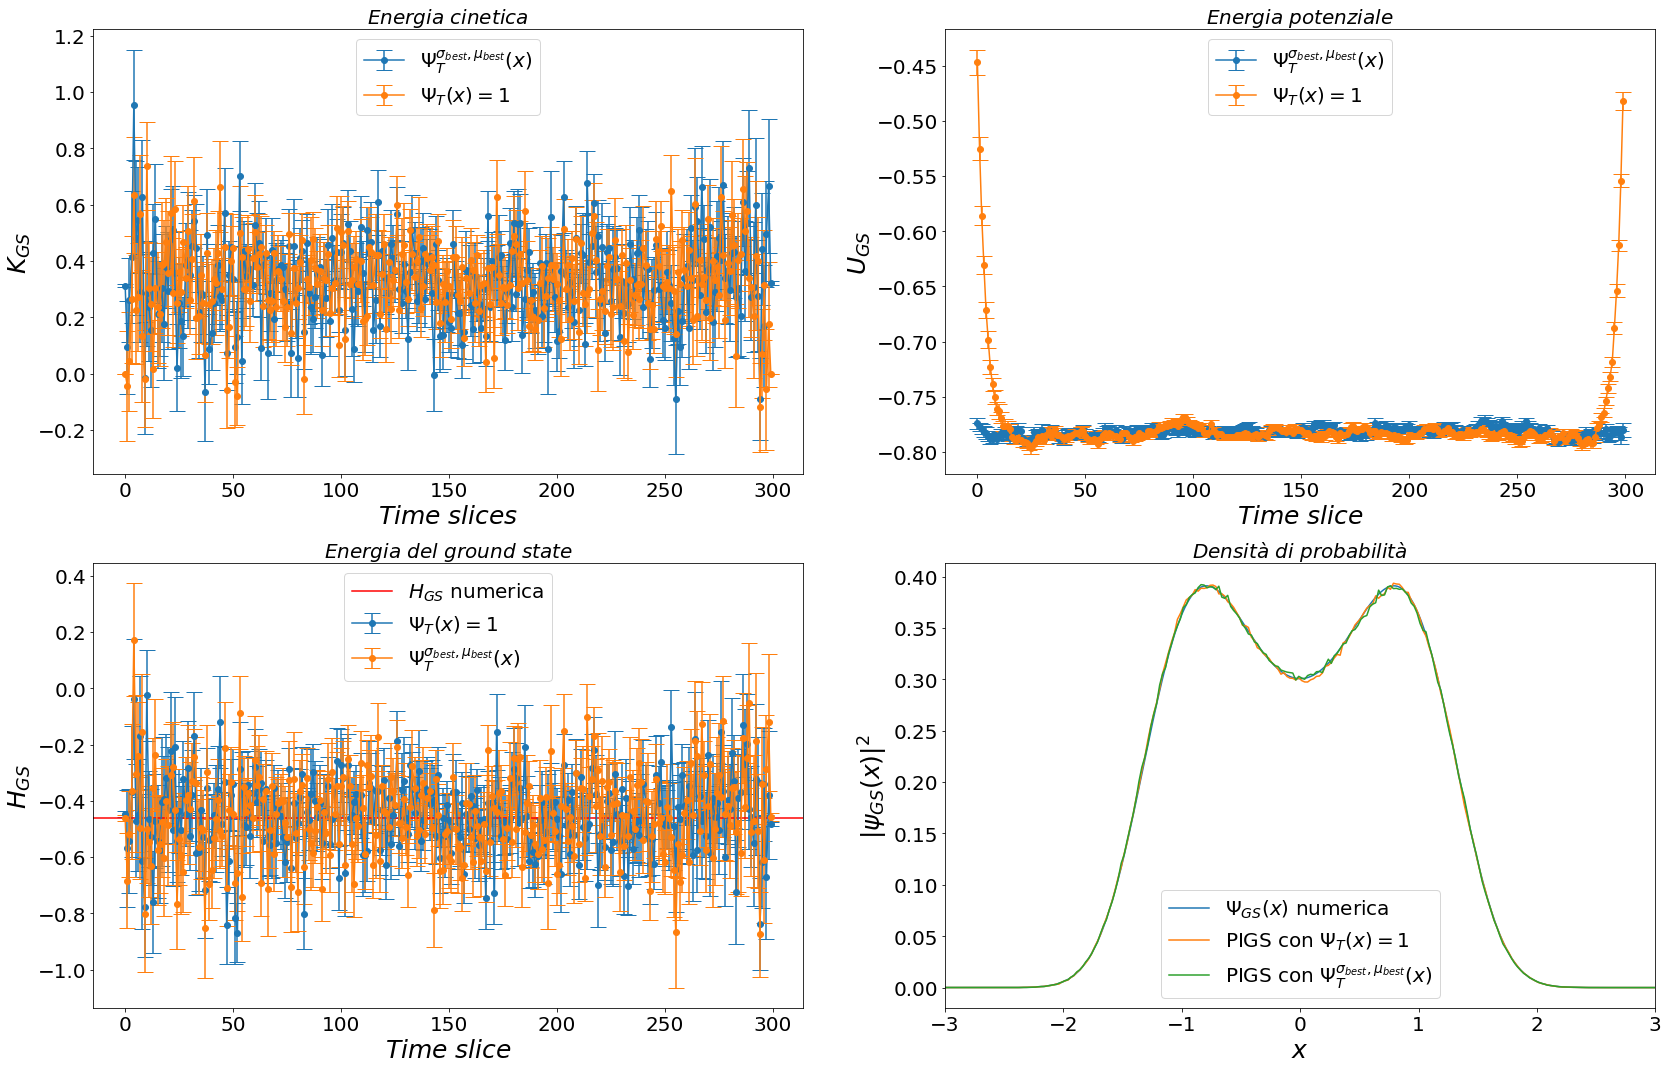

In [248]:
plt.figure(figsize=(28,18))

plt.subplot(2,2,1)

#Energia cinetica
y, k_v, err_kv=np.loadtxt("QMC_1D/kinetic_var.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
x, k, err_k=np.loadtxt("QMC_1D/kinetic_const.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(y,k_v,yerr=err_kv, marker= 'o', capsize=8, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$')
plt.errorbar(x,k,yerr=err_k, marker= 'o', capsize=8, label='$\Psi_T(x)=1$')
plt.title('$Energia$ $cinetica$', fontsize=20)
plt.ylabel('$K_{GS}$',fontsize=25)
plt.xlabel('$Time$ $slices$',fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(2,2,2)

#Energia potenziale

y, p_v, err_pv=np.loadtxt("QMC_1D/potential_var.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
x, p, err_p=np.loadtxt("QMC_1D/potential_const.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(y, p_v,yerr=err_pv, marker= 'o', capsize=8, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$')
plt.errorbar(x, p,yerr=err_p, marker= 'o', capsize=8, label='$\Psi_T(x)=1$')
plt.title('$Energia$ $potenziale$', fontsize=20)
plt.ylabel('$U_{GS}$',fontsize=25)
plt.xlabel('$Time$ $slice$',fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(2,2,3)

#Energia del ground state

plt.errorbar(x,k+p,yerr=err_k+err_p, marker= 'o', capsize=8, label='$\Psi_T(x)=1$')
plt.errorbar(y,k_v+p_v,yerr=err_kv+err_pv, marker= 'o', capsize=8, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$')
plt.ylabel('$H_{GS}$',fontsize=25)
plt.xlabel('$Time$ $slice$',fontsize=25)
plt.title('$Energia$ $del$ $ground$ $state$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y= -0.46046587969271563 , color='red', label='$H_{GS}$ numerica')
plt.legend(loc='best', fontsize=20)

plt.subplot(2,2,4)

#Funzione d'onda stato fondamentale

x_c , y_c = np.loadtxt("QMC_1D/probability_const.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_v , y_v= np.loadtxt("QMC_1D/probability_var.dat", usecols=(0,1), delimiter=' ', unpack='true')

plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica')
plt.plot(x_c,y_c, label='PIGS con $\Psi_T(x)=1$')
plt.plot(x_v,y_v, label='PIGS con $\Psi_T^{\sigma_{best},\mu_{best}}(x)$')
plt.xlabel("$x$", fontsize=25)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=25)
plt.xlim(-3,3)
plt.title('$Densità$ $di$ $probabilità$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

Dai risultati vediamo che in entrambi i casi analizzati le funzioni d'onda trovate per il ground state coincidono tra loro nonostante si sia partiti da funzioni d'onda di prova molto diverse e coincidono anche con la soluzione numerica. L'energia del ground state in entrambi i casi è compatibile con quella effettiva calcolata tramite discretizzazione del problema di Schrodinger.

- Confrontiamo ora i risultati ottenuti con PIGS con quelli ricavati dal codice Variational Monte Carlo utilizzando per entrambi la funzione di prova ottimizzata $\Psi_T^{\sigma_{best},\mu_{best}}(x)$. 

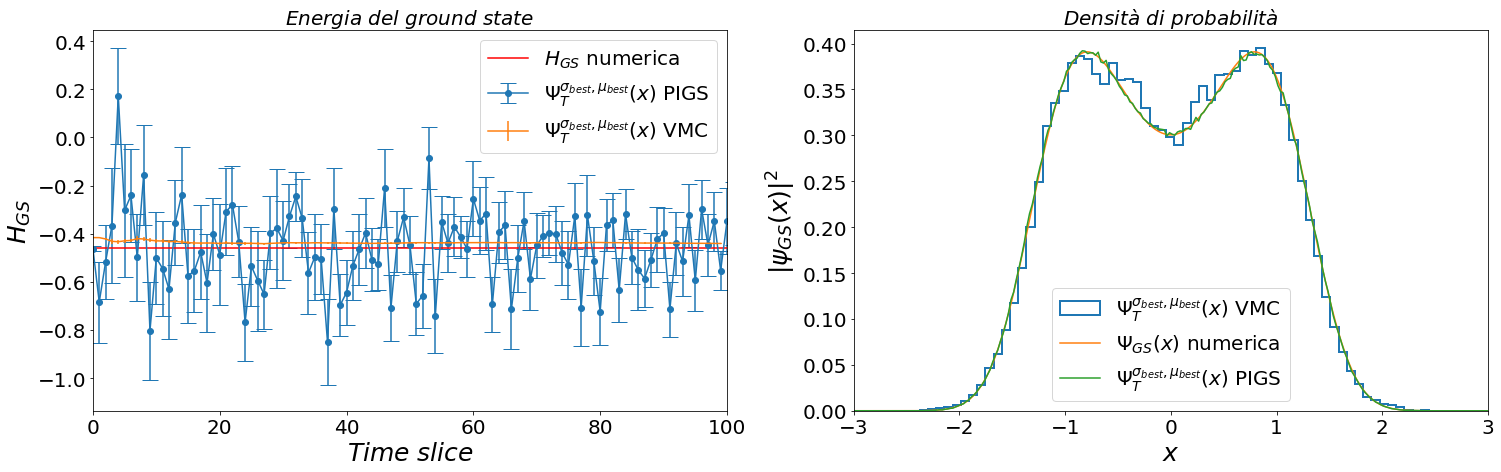

In [261]:
plt.figure(figsize=(25,7))

y, p_v, err_pv=np.loadtxt("QMC_1D/potential_var.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
y, k_v, err_kv=np.loadtxt("QMC_1D/kinetic_var.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
x, h, err_h= np.loadtxt("VMC/hamiltonian.dat", usecols=(0,1,2), delimiter=' ', unpack='true')


plt.subplot(1,2,1)

#Energia del ground state

plt.errorbar(y,k_v+p_v,yerr=err_kv+err_pv, marker= 'o', capsize=8, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ PIGS')
plt.errorbar(x,h,yerr=err_h, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ VMC')
plt.ylabel('$H_{GS}$',fontsize=25)
plt.xlabel('$Time$ $slice$',fontsize=25)
plt.title('$Energia$ $del$ $ground$ $state$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,100)
plt.axhline(y= -0.46046587969271563 , color='red', label='$H_{GS}$ numerica')
plt.legend(loc='best', fontsize=20)




plt.subplot(1,2, 2)

#Funzione d'onda stato fondamentale

x_v , y_v= np.loadtxt("QMC_1D/probability_var.dat", usecols=(0,1), delimiter=' ', unpack='true')
x= np.loadtxt("VMC/configurations.dat", usecols=0, unpack='true')
plt.hist(x, bins='auto', label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ VMC', histtype='step', linewidth=2, density=True)
plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica')
plt.plot(x_v,y_v, label='$\Psi_T^{\sigma_{best},\mu_{best}}(x)$ PIGS')
plt.xlabel("$x$", fontsize=25)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=25)
plt.xlim(-3,3)
plt.title('$Densità$ $di$ $probabilità$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

Dai grafici vediamo che i risultati ottenuti con le due tecniche sono compatibili tra di loro e sono a loro volta compatibili con la soluzione numerica.

- Cerchiamo ora di capire quanto possiamo ridurre il tempo di propagazione immaginario ottenendo risultati compatibili con quelli attesi rispetto al tempo immaginario utilizzato finora che è pari a $\tau=8$. Facciamo questa analisi sia per la funzione di prova costante sia per la funzione di prova ottimizzata.

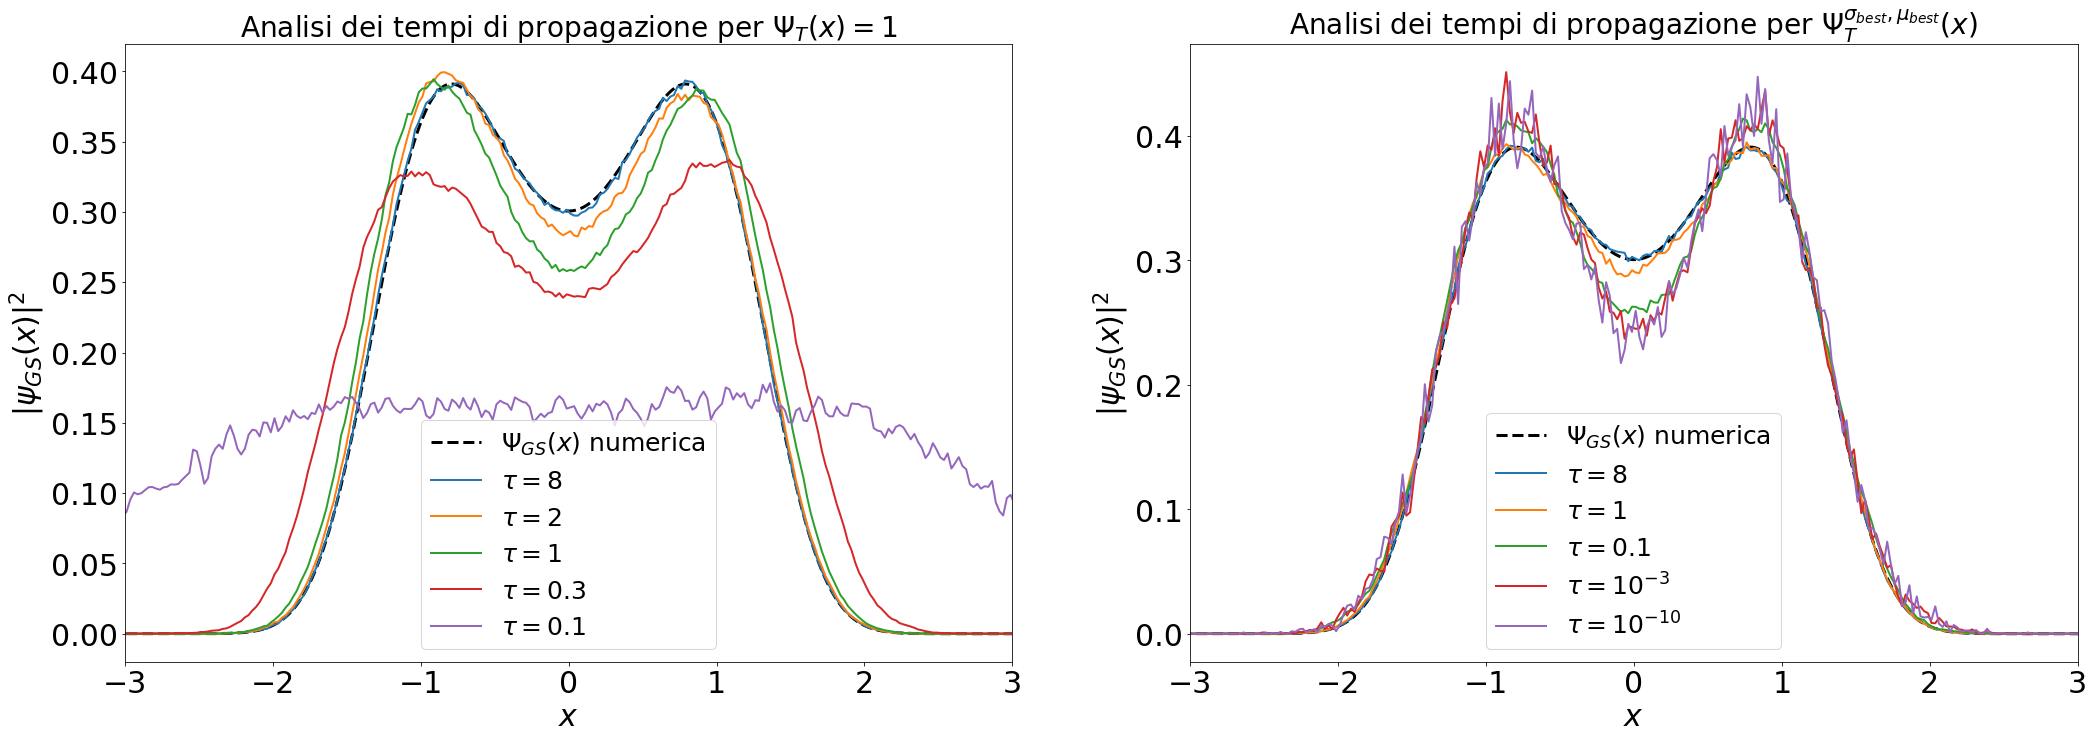

In [267]:
plt.figure(figsize=(35,25))

plt.subplot(2,2,1)

x_8,y_8=np.loadtxt("QMC_1D/probability_const.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_2,y_2=np.loadtxt("QMC_1D/prob_const_imgtime2.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_1,y_1=np.loadtxt("QMC_1D/prob_const_imgtime1.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_03,y_03=np.loadtxt("QMC_1D/prob_const_imgtime03.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_01,y_01=np.loadtxt("QMC_1D/prob_const_imgtime01.dat", usecols=(0,1), delimiter=' ', unpack='true')

plt.title('Analisi dei tempi di propagazione per $\Psi_T(x)=1$', fontsize =28)

plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica', c='black', linestyle='--' , linewidth=3)
plt.plot(x_8,y_8, label='$\\tau=8$', linewidth=2)
plt.plot(x_2,y_2, label='$\\tau=2$', linewidth=2)
plt.plot(x_1,y_1, label='$\\tau=1$', linewidth=2)
plt.plot(x_03,y_03, label='$\\tau=0.3$', linewidth=2)
plt.plot(x_01,y_01, label='$\\tau=0.1$', linewidth=2)
plt.xlabel("$x$", fontsize=30)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(-3,3)
plt.legend(loc='best', fontsize=25)
#plt.grid()

plt.subplot(2,2,2)

x_8,y_8=np.loadtxt("QMC_1D/probability_var.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_1,y_1=np.loadtxt("QMC_1D/prob_var_imgtime1.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_01,y_01=np.loadtxt("QMC_1D/prob_var_imgtime01.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_001,y_001=np.loadtxt("QMC_1D/prob_var_imgtime001.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_m10,y_m10=np.loadtxt("QMC_1D/prob_var_imgtimem10.dat", usecols=(0,1), delimiter=' ', unpack='true')

plt.title('Analisi dei tempi di propagazione per $\Psi_T^{\sigma_{best},\mu_{best}}(x)$', fontsize =28)

plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica', c='black', linestyle='--' , linewidth=3)
plt.plot(x_8,y_8, label='$\\tau=8$', linewidth=2)
plt.plot(x_1,y_1, label='$\\tau=1$', linewidth=2)
plt.plot(x_01,y_01, label='$\\tau=0.1$', linewidth=2)
plt.plot(x_001,y_001, label='$\\tau=10^{-3}$', linewidth=2)
plt.plot(x_m10,y_m10, label='$\\tau=10^{-10}$', linewidth=2)
plt.xlabel("$x$", fontsize=30)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(-3,3)
plt.legend(loc='best', fontsize=25)
#plt.grid()

plt.show()

Dai grafici vediamo che per la funzione di prova costante possiamo scendere a tempi di propagazione di circa 
$\tau=2$ per ottenere un risultato compatibile con quello atteso numericamente. Per la funzione d'onda ottimizzata invece possiamo scendere a valori pari a circa $\tau=1$.

- Facciamo ora delle simulazioni a temperatura $T$ finita maggiore di zero (PIMC), confrontiamo poi i risultati ottenuti con la soluzione numerica della funzione d'onda dello stato fondamentale. 

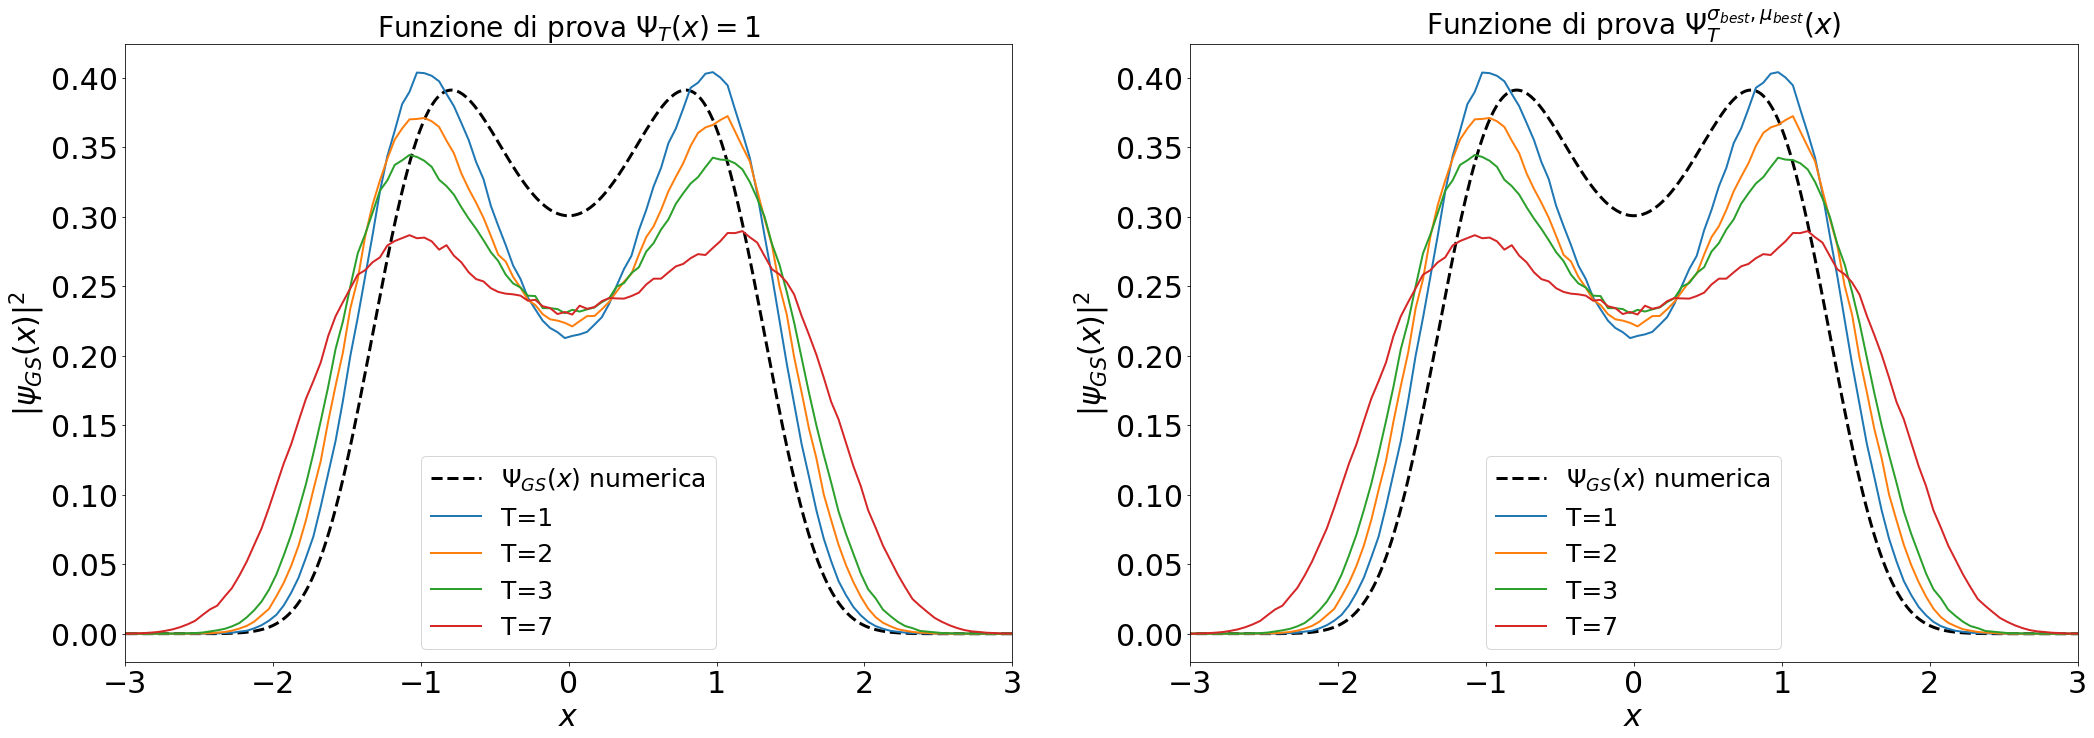

In [293]:
plt.figure(figsize=(35,25))

plt.subplot(2,2,1)

plt.title('Funzione di prova $\Psi_T(x)=1$', fontsize =28)

x_c1 , y_c1 = np.loadtxt("QMC_1D/probability_T=1const.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_c2 , y_c2 = np.loadtxt("QMC_1D/probability_T=2const.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_c3 , y_c3 = np.loadtxt("QMC_1D/probability_T=3const.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_c7 , y_c7 = np.loadtxt("QMC_1D/probability_T=7const.dat", usecols=(0,1), delimiter=' ', unpack='true')

plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica', c='black', linestyle='--' , linewidth=3)
plt.plot(x_c1,y_c1, linewidth=2, label='T=1')
plt.plot(x_c2,y_c2, linewidth=2, label='T=2')
plt.plot(x_c3,y_c3, linewidth=2, label='T=3')
plt.plot(x_c7,y_c7, linewidth=2, label='T=7')
plt.xlabel("$x$", fontsize=30)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc='best', fontsize=25)
#plt.grid()
plt.xlim(-3,3)


plt.subplot(2,2,2)

x_v1 , y_v1= np.loadtxt("QMC_1D/probability_T=1var.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_v2 , y_v2= np.loadtxt("QMC_1D/probability_T=2var.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_v3 , y_v3= np.loadtxt("QMC_1D/probability_T=3var.dat", usecols=(0,1), delimiter=' ', unpack='true')
x_v7 , y_v7= np.loadtxt("QMC_1D/probability_T=7var.dat", usecols=(0,1), delimiter=' ', unpack='true')

plt.title('Funzione di prova $\Psi_T^{\sigma_{best},\mu_{best}}(x)$', fontsize =28)

plt.plot(x_num,(psi[0])**2, label='$\Psi_{GS}(x)$ numerica', c='black', linestyle='--' , linewidth=3)
plt.plot(x_v1,y_v1, linewidth=2, label='T=1')
plt.plot(x_v2,y_v2, linewidth=2, label='T=2')
plt.plot(x_v3,y_v3, linewidth=2, label='T=3')
plt.plot(x_v7,y_v7, linewidth=2, label='T=7')
plt.xlabel("$x$", fontsize=30)
plt.ylabel("$|\psi_{GS}(x)|^2$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(-3,3)
plt.legend(loc='best', fontsize=25)
#plt.grid()

plt.show()

Dall'andamento dei grafici vediamo che simulando il sistema a temperature finite e diverse da zero la larghezza della densità di probabilità cambia perché vengono popolati altri stati eccitati diversi dal ground state. Il modulo quadro della funzione d'onda per temperature diverse da zero sarà ottenuto da una miscela di funzioni d'onda.